# Leakage assessment

This notebook showcases usage of **pyecsca** to reverse-engineer an implementation
configuration utilizing a leakage assessment technique based on the Welch's t-test.

## Implementation and scope setup

We will be reversing an implementation on the `STM32F3` board, using a PicoScope 5000 oscilloscope.
The implementation uses the left-to-right double and add multiplier, Short Weierstrass curve model,
projective coordinate system and the `add-1998-cmo`, `dbl-1998-cmo` formulas.

In [1]:
import tempfile

from os.path import join
from pyecsca.codegen.common import Platform, DeviceConfiguration
from pyecsca.codegen.render import render_and_build
from pyecsca.ec.model import ShortWeierstrassModel
from pyecsca.ec.mult import LTRMultiplier
from pyecsca.ec.configuration import *

platform = Platform.STM32F3
hash_type = HashType.SHA1
mod_rand = RandomMod.REDUCE
mult = Multiplication.BASE
sqr = Squaring.BASE
red = Reduction.BARRETT
inv = Inversion.GCD

model = ShortWeierstrassModel()
coords = model.coordinates["projective"]
add = coords.formulas["add-2016-rcb"]
dbl = coords.formulas["dbl-2016-rcb"]
formulas = [add, dbl]
scalarmult = LTRMultiplier(add, dbl, complete=True, always=True)

config = DeviceConfiguration(model, coords, formulas, scalarmult, hash_type, mod_rand, mult, sqr, red, inv,
                             platform, True, True, True)

tmpdir = tempfile.TemporaryDirectory()
directory, elf_file, hex_file, res = render_and_build(config, tmpdir.name)
fw = join(tmpdir.name, hex_file)
print(fw)

/tmp/tmpaogthcdx/pyecsca-codegen-CW308_STM32F3.hex


In [2]:
from pyecsca.sca.scope.picoscope_sdk import PS5000Scope
from pyecsca.sca.scope import SampleType

scope = PS5000Scope()
scope.open()
scope.setup_channel(channel="A", coupling="AC", range=0.2, offset=0.0, enable=True)
scope.setup_channel(channel="B", coupling="DC", range=5.0, offset=0.0, enable=True)
scope.setup_frequency(frequency=5_161_290, pretrig=0, posttrig=16_000_000)
scope.setup_trigger(channel="B", threshold=1.0, direction="rising", delay=0, timeout=20000, enable=True)
scope.setup_capture(channel="A", enable=True)
print("Scope", scope.get_variant(), "connected.")

Scope 5203  connected.


## Trace acquisition

We will collect 200 traces of the target generating a keypair on the `secp128r1` curve.

In [3]:
from pyecsca.sca.trace import Trace
from pyecsca.ec.params import get_params
from pyecsca.codegen.client import DeviceTarget, Triggers
from pyecsca.sca.trace_set import HDF5TraceSet
from time import sleep, time
import gc

In [4]:
params = get_params("secg", "secp128r1", "projective")
target = DeviceTarget(model=params.curve.model, coords=params.curve.coordinate_model, platform=config.platform, timeout=5000)
target.flash(fw)

hdf5 = HDF5TraceSet.inplace(join(tmpdir.name, "traces.h5"))

target.connect()
target.set_params(params)
target.set_trigger(Triggers.keygen)
for i in range(10):
    scope.arm()
    sleep(3)
    start = time()
    priv, pub = target.generate()
    end = time()
    print(end - start, priv, pub)
    scope.capture(5000)
    trace = scope.retrieve("A", SampleType.Volt)
    trace.meta["priv"] = priv
    trace.meta["pub"] = pub
    hdf5.append(trace)
    %xdel trace
    gc.collect()
    sleep(0.5)
target.disconnect()
#hdf5.close()

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 24379 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 24379 bytes
Serial baud rate = 38400
Serial baud rate = 38400
Serial baud rate = 115200
4.8725035190582275 177309395205785581905451638929711326924 [x=254418971706087262781769412192738375543, y=222530869799019713391791546823181031470]
4.72023606300354 100845768388402979303559149029177659704 [x=106923580136821844041823907110692418351, y=156435830676948297677654863164189028187]
4.846437931060791 227397999055773150518931153324621788836 [x=156549992730653463452093185504191885104, y=265555465204529245390039080674082793630]
4.8568620681762695 49876835576938472301483522327569819692 [x=97251286668223703970926334993165929391, y=183947853544365719068508354888819873362]
4.6602513790130615 6741449615229322618317253203808632318 [x=9117898002351170563448903

## Cleanup

In [5]:
target.scope.dis()
scope.close()

## Analysis

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
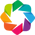

In [6]:
from pyecsca.sca.trace.plot import plot_traces, plot_trace
import holoviews as hv

hv.extension("bokeh")

In [2]:
hdf5 = HDF5TraceSet.inplace(join(tmpdir.name, "traces.h5"))

NameError: name 'join' is not defined

In [9]:
from pyecsca.sca.trace.filter import filter_lowpass

low1 = filter_lowpass(hdf5[0], 5_161_290, 9_000)
low2 = filter_lowpass(hdf5[1], 5_161_290, 9_000)
low3 = filter_lowpass(hdf5[2], 5_161_290, 9_000)

In [10]:
plot_traces(low1, low3).opts(width=950, height=600)

:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [x,y]   (R,G,B,A)
      .RGB.II :RGB   [x,y]   (R,G,B,A)

In [11]:
from scipy.signal import find_peaks

In [12]:
peaks1 = find_peaks(low1.samples, height=0.009)
peaks2 = find_peaks(low2.samples, height=0.009)

In [36]:
for i in range(len(peaks1[0])-1):
    print(peaks1[0][i+1] - peaks1[0][i])

493
81123
111032
101033
114207
94018
97779
94124
93933
93633
89541
100029
88076
87052
95178
88518
115922
100335
112304
95492
98084
111239
83510
87256
100407
96973
108631
85753
89993
90432
92218
90611
99536
82524
94464
100614
97517
92187
98261
89561
97258
99131
84409
98408
97273
92746
98820
100489
96369
102502
114490
80942
91684
87205
96678
96149
112678
94323
105718
97213
112085
95402
107133
102969
102886
86849
116751
90838
104644
96112
103006
99962
98602
87510
110866
94893
106245
101159
113916
90343
106824
89955
88566
89216
106356
103071
96647
94450
117445
82232
102134
98497
115128
102681
87768
91884
104964
97023
106224
100463
87330
99563
100059
93382
108739
100875
94972
102596
113221
95156
97096
92026
105496
81695
110967
96239
102788
102579
107816
95818
103487
85783
99799
94540
87269
98119
121269
91549
91792
97697
84458
87308
93838
86969
100011
94545
100521
97177
114142
93893
101654
90886
95016
95771
99779
96746
109341
83843
91058
93044
100489
99657
94647
95956
109482
93062
105833
942

In [15]:
from pyecsca.sca.trace import trim

In [33]:
l1peak1 = trim(low1, peaks1[0][2], peaks1[0][3])
l2peak1 = trim(low2, peaks2[0][3], peaks2[0][4])

In [38]:
from pyecsca.sca.trace import align_dtw

In [43]:
ts = align_dtw(l2peak1, l1peak1)

In [50]:
plot_traces(l2peak1, ts[1]).opts(width=950, height=600)

:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [x,y]   (R,G,B,A)
      .RGB.II :RGB   [x,y]   (R,G,B,A)

NameError: name 'trace' is not defined